In [1]:
### BH + Bulge (Hernquist profile) - Analysis code ### 

In [95]:
# About the code #

# The code is divided into five main Sections: 
# 1 - Setting of useful parameters
# 2 - Definition and filling of the time array 
# 3 - Energy section 
# 4 - Position section 
# 5 - Stability Section 

In [96]:
###################################################################################################################

In [97]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
## Section 1 - Setting of useful parameters (Nparticles,TotMass,ScaleRadiusSphere,Nsnapshots) ##

In [6]:
## Number of bodies, total mass in stars, BH's mass and scale radius of the sphere 
Nbodies,M,M_BH,r_scale = np.loadtxt('system_properties.txt')

Nbodies = int(Nbodies)
Nparticles = Nbodies-1
m = M/Nparticles # mass of a single particle

Nlines_in_snapshot = 3+4*Nbodies # Nbodies(1row)+Ndimensions(1)+time(1)+mass_bodies(N)+
                                    # +positions(N)+velocities(N)+potential_energy(N)

## Number of snapshot in 'output_data.txt'
data = open("output_data.txt", "r")	
Nlines = len(data.readlines())
Nsnapshots = Nlines/Nlines_in_snapshot # total number of temporal steps saved 
Nsnapshots = int(Nsnapshots)
data.close()

In [7]:
###################################################################################################################

In [8]:
## Section 2 - Definition and filling of the time array ## 

In [9]:
t = np.empty([Nsnapshots])
for i_snapshot in range(Nsnapshots):
    initial_line = i_snapshot*Nlines_in_snapshot
    initial_line_time = initial_line+2
    t[i_snapshot] = np.genfromtxt("output_data.txt",skip_header=initial_line_time,max_rows=1)

In [10]:
###################################################################################################################

In [11]:
## Section 3 - Energy section ##

In [12]:
# In this Section are computed, for selected snapshots, the total kinetic and the total potential energies per 
# unit mass.
# Pay attention that the computational time for these part is quite long (as the amount of particles and the number 
# of selected snapshots increase, so will do the computational time)
# The kinetic energy, the potential energy and the total energy (sum of the previous ones) are then plotted respect
# to time.
# The total energy, in principle, should be preserved at every time and should be equal to the total energy at t=0;
# for this reason is presented the graph of '(Etot(t)-Etot(t=0))/Etot(t=0) vs. time' that gives an idea of the 
# conservation of energy deviation (the non perfect conservation of energy is due to computational approximations)

In [13]:
print('Nsnapshots: {}'.format(Nsnapshots))

Nsnapshots: 64


In [14]:
## Snapshot selection
# In order to decrease the computational cost we give the possibility to select and reduce the number of
# snapshots that will be analyzed in this Section. The selected snapshots starts from the first one and are
# separated by 'step'. For analyze all the snapshots choose 'step=1'
sn = 0
step = 4 # to decrease computational costs, put one for all snapshots
selected_snapshot = []
for i in range(int(Nsnapshots/step)):
    selected_snapshot.append(step*i)

In [15]:
## Definiton and filling of the kinetic and potential energies at the selected snapshots
Utot = np.zeros([len(selected_snapshot)])
Ktot = np.zeros([len(selected_snapshot)])

for i_snapshot in range(len(selected_snapshot)):
    initial_line = i_snapshot*Nlines_in_snapshot
    initial_line_velocity = initial_line+3+2*Nbodies
    initial_line_potential = initial_line+3+3*Nbodies
    for i_particle in range(Nbodies):            
        vx = np.genfromtxt("output_data.txt",skip_header=initial_line_velocity+i_particle,usecols=0,max_rows=1) # i_particle's x_velocity at time=t[i_snapshot]
        vy = np.genfromtxt("output_data.txt",skip_header=initial_line_velocity+i_particle,usecols=1,max_rows=1)
        vz = np.genfromtxt("output_data.txt",skip_header=initial_line_velocity+i_particle,usecols=2,max_rows=1)        
        Utot[i_snapshot] = Utot[i_snapshot]+np.genfromtxt("output_data.txt",skip_header=initial_line_potential+i_particle,max_rows=1)
        Ktot[i_snapshot] = Ktot[i_snapshot]+0.5*(vx**2 + vy**2 + vz**2)             
Utot = Utot*0.5 # to avoid the double counting for the potential energy  


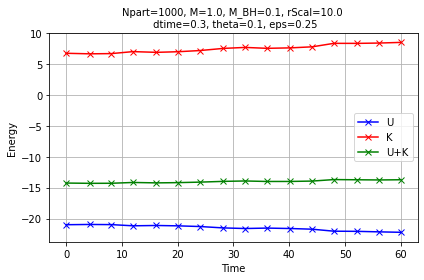

In [42]:
## Plot of the ptential energy (U), kinetic energy(K), total energy(U+K)
plt.title('Npart={}, M={}, M_BH={}, rScal={} \n dtime=0.3, theta=0.1, eps=0.25'.format(Nparticles,M,M_BH,r_scale), fontsize=10,loc='center', pad=None)
plt.plot(t[selected_snapshot],Utot,c='b',label='U',marker='x')
plt.plot(t[selected_snapshot],Ktot,c='r',label='K',marker='x')
plt.plot(t[selected_snapshot],Ktot+Utot,c='g',label='U+K',marker='x')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.grid()
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('energy_plot.jpg')

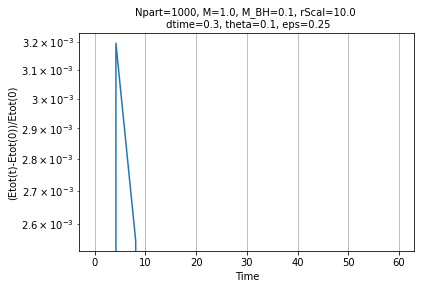

In [43]:
## Plot of '(TotalEnergy(t)-TotalEnergy(t=0))/TotalEnergy(t=0)  vs. Time'
diff = ((Utot+Ktot)-(Utot[0]+Ktot[0]))/(Utot[0]+Ktot[0])
plt.plot(t[selected_snapshot],diff)
plt.title('Npart={}, M={}, M_BH={}, rScal={} \n dtime=0.3, theta=0.1, eps=0.25'.format(Nparticles,M,M_BH,r_scale), fontsize=10,loc='center', pad=None)
plt.xlabel('Time')
plt.ylabel('(Etot(t)-Etot(0))/Etot(0)')
plt.yscale('log')
plt.grid()
plt.savefig('energy_diff_plot.jpg')

In [18]:
###################################################################################################################

In [19]:
## Section 4 - Position section ##

In [98]:
# This Section is divided into three subsections

# -Subsection 1: Lagrangian Radius computed at the selected snapshots

# -Subsection 2: Among the particles, Nsamples are selected and at each time step their distance is computed respect 
#                to the center (the distance is saved into an array D([Nsnapshots,Nsamples]) ).
#                The samples are not chosen by random sampling, but using a particular process:
#                after have chosen the number n of samples and the radius, R, whithin which the samples are chosen
#                I split R in n intervals. For each interval I take a particle that at t=0 belongs to it and 
#                if the code cannot find any particle, it is chosen randomly. Thanks to this process we have a 
#                better sample of particles within the chosen radius, respect to a random selection. 
#                Advise: for computational costs and for plotting clarity is convenient to choose a small sample

In [56]:
# Subsection 1 - Lagrangian Radius #

In [57]:
## Snapshot selection
sn = 0
step = 4
selected_snapshot = []
for i in range(int(Nsnapshots/step)):
    selected_snapshot.append(step*i)

In [58]:
## Definition and computation of the Lagrangian Radius Arrays 
LagRad20 = np.empty([len(selected_snapshot)])
LagRad40 = np.empty([len(selected_snapshot)])
LagRad60 = np.empty([len(selected_snapshot)])
LagRad80 = np.empty([len(selected_snapshot)])

dist = np.empty([Nparticles])
for i_snapshot in range(len(selected_snapshot)):
    initial_line = i_snapshot*Nlines_in_snapshot
    initial_line_position = initial_line+3+Nbodies 
    for i_particle in range(Nparticles):
        x = np.genfromtxt("output_data.txt",skip_header=initial_line_position+i_particle+1,usecols=0,max_rows=1) # +1 because I avoid the BH
        y = np.genfromtxt("output_data.txt",skip_header=initial_line_position+i_particle+1,usecols=1,max_rows=1)
        z = np.genfromtxt("output_data.txt",skip_header=initial_line_position+i_particle+1,usecols=2,max_rows=1)
        dist[i_particle] = (x**2+y**2+z**2)**(1/2)
    sortArray = np.sort(dist)
    LagRad20[i_snapshot] = sortArray[int(0.2*Nparticles)-1]
    LagRad40[i_snapshot] = sortArray[int(0.4*Nparticles)-1]
    LagRad60[i_snapshot] = sortArray[int(0.6*Nparticles)-1]
    LagRad80[i_snapshot] = sortArray[int(0.8*Nparticles)-1]

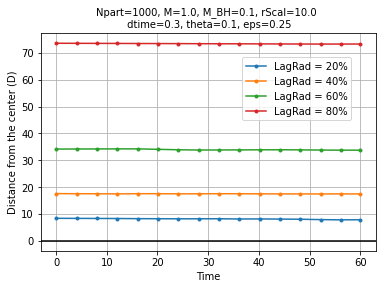

In [59]:
## Plot of the Lagrangian radius
plt.plot(t[selected_snapshot],LagRad20,label='LagRad = 20%',marker='.')
plt.plot(t[selected_snapshot],LagRad40,label='LagRad = 40%',marker='.')
plt.plot(t[selected_snapshot],LagRad60,label='LagRad = 60%',marker='.')
plt.plot(t[selected_snapshot],LagRad80,label='LagRad = 80%',marker='.')
plt.grid()
plt.title('Npart={}, M={}, M_BH={}, rScal={} \n dtime=0.3, theta=0.1, eps=0.25'.format(Nparticles,M,M_BH,r_scale), fontsize=10,loc='center', pad=None)
plt.axhline(0,0,1,c='k',ls='-')
plt.xlabel('Time')
plt.ylabel('Distance from the center (D)')
plt.legend(loc=(0.6,0.6))
plt.savefig('LagrangianRadius.jpg')

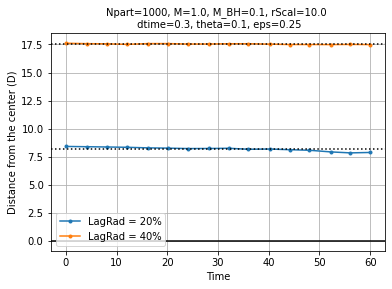

In [60]:
## Plot of only two Lagrangian radius and of the corrispondent mean (only two for a better visualization)
plt.plot(t[selected_snapshot],LagRad20,label='LagRad = 20%',marker='.')
plt.plot(t[selected_snapshot],LagRad40,label='LagRad = 40%',marker='.')
mean20 = sum(LagRad20)/len(LagRad20)
mean40 = sum(LagRad40)/len(LagRad40)
plt.axhline(mean20,0,1,c='k',ls=':')
plt.axhline(mean40,0,1,c='k',ls=':')
plt.grid()
plt.title('Npart={}, M={}, M_BH={}, rScal={} \n dtime=0.3, theta=0.1, eps=0.25'.format(Nparticles,M,M_BH,r_scale), fontsize=10,loc='center', pad=None)
plt.axhline(0,0,1,c='k',ls='-')
plt.xlabel('Time')
plt.ylabel('Distance from the center (D)')
plt.legend(loc='best')
plt.savefig('LagrangianRadiusMean.jpg')

In [61]:
# Subsection 2 - Position evolution of some particles #

In [62]:
Nsamples = 5
radius = r_scale*1
delta = radius/Nsamples 
sample_index = np.ones([Nsamples])*(-1) # array where will be saved the indexes of the particles chosen as samples
                                        # initialized in this way for the while cicle that follows
for i in range(Nsamples):
    i_particle = 0      
    while (sample_index[i]==-1) == True:
        x = np.genfromtxt("output_data.txt",skip_header=3+Nparticles+1+i_particle,usecols=0,max_rows=1) # plus 1 to avoid the BH
        y = np.genfromtxt("output_data.txt",skip_header=3+Nparticles+1+i_particle,usecols=1,max_rows=1)
        z = np.genfromtxt("output_data.txt",skip_header=3+Nparticles+1+i_particle,usecols=2,max_rows=1)
        dist = (x**2+y**2+z**2)**(1/2)              
        if dist<=(radius-delta*i) and dist>(radius-delta*(i+1)):
            sample_index[i] = i_particle
        elif i_particle == Nparticles-1:
            sample_index[i] = np.random.randint(0, Nparticles-1) # random selection
        else: i_particle = i_particle+1

# The code written above should be improved as follow: selection of a particle, computation of its distance respect
# to the center and association to the corrispondent radius interval (if no particle has been associated yet); in
# the code above instead when a particle is found, the search for the other one restarts from the beginning.

In [63]:
## saving the Nsamples' positions, at each snapshot, in D
D = np.empty([Nsnapshots,Nsamples]) 
for i_snapshot in range(Nsnapshots):
    initial_line = i_snapshot*Nlines_in_snapshot
    initial_line_position = initial_line+3+Nparticles+1 # plus 1 to avoid the BH
    for i_sample in range(Nsamples):
        i_particle = int(sample_index[i_sample])
        x = np.genfromtxt("output_data.txt",skip_header=initial_line_position+i_particle,usecols=0,max_rows=1)
        y = np.genfromtxt("output_data.txt",skip_header=initial_line_position+i_particle,usecols=1,max_rows=1)
        z = np.genfromtxt("output_data.txt",skip_header=initial_line_position+i_particle,usecols=2,max_rows=1)
        D[i_snapshot][i_sample] = (x**2+y**2+z**2)**(1/2)

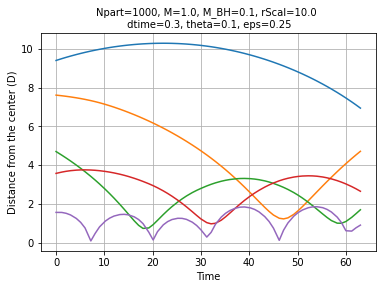

In [64]:
plt.plot(t,D,label='particle_path')
plt.grid()
plt.title('Npart={}, M={}, M_BH={}, rScal={} \n dtime=0.3, theta=0.1, eps=0.25'.format(Nparticles,M,M_BH,r_scale), fontsize=10,loc='center', pad=None)
plt.xlabel('Time')
plt.ylabel('Distance from the center (D)')
plt.savefig('Positions.jpg')

In [46]:
###################################################################################################################

In [47]:
## Section 5 - Stability Section ##

In [65]:
# This Section can be used to check if the positions distributions (the distribution of R, theta and phi) have 
# changed over time or if they preserved themselves.
# This analysis is made both qualitatively (histogram) and quantitatively (chisquare test) for the R,theta and phi
# distributions.
# About the histograms and the statistical choices:
# - we decided to use the 'auto' number of bins selection: if the histogram is not too satisfactory or if the
#   chi-square test is not passed, try to give manually an appropiate bin selection
# - we used a chi square distribution test to verify how well the theoretical distribution fitted the empirical 
#   ones. To use the chi-square distribution we considered only bins with a number of counts greater than 9.
# - we plot on the normalized histograms the error bars. We assume a Poissonian distribution for the counts and
#   so the error associated to each bin is the square root of the number of counts in that bin; for the normalized
#   histogram's error bars we rescale the error dividing it by the area of the non-normalized histogram (it's maybe
#   a non correct procedure)

# you need to run, before running this Section, the Section 1 and 2

In [66]:
from scipy.stats import chisquare

In [67]:
snapshot_to_check = Nsnapshots-1
file_name = "output_data.txt"

In [68]:
# Subsection 1 - Check of the Position distribution #

In [69]:
radius = np.empty([Nparticles]) 
theta = np.empty([Nparticles])
phi = np.empty([Nparticles])

initial_line = snapshot_to_check*Nlines_in_snapshot
initial_line_position = initial_line+3+Nbodies
for i_particle in range(Nparticles):
        x = np.genfromtxt(file_name,skip_header=initial_line_position+i_particle+1,usecols=0,max_rows=1) # +1 because I avoid the BH
        y = np.genfromtxt(file_name,skip_header=initial_line_position+i_particle+1,usecols=1,max_rows=1)
        z = np.genfromtxt(file_name,skip_header=initial_line_position+i_particle+1,usecols=2,max_rows=1)
        radius[i_particle] = (x**2+y**2+z**2)**(1/2)
        theta[i_particle] = math.acos(z/radius[i_particle])
        phi[i_particle] = math.atan2(y,x)
phi = phi+math.pi

In [70]:
## Radius Distribution

In [74]:
## pdf and cdf of the radial positions 
def pdf_r(b,r):
    return 2*b*r/(r+b)**3
def cdf_r(b,r):
    return 1-(b**2+2*b*r)/(r+b)**2

In [82]:
# Chisquare Section #

empirical,edges = np.histogram(radius,bins='auto')
counts = np.copy(empirical) # used in the histogram section
theorical = []
for i_bin in range(len(empirical)):
    if empirical[i_bin]>9:
        prob = cdf_r(r_scale,edges[i_bin+1]) - cdf_r(r_scale,edges[i_bin])
        theorical.append(prob*Nparticles)        
empirical = empirical[empirical>9] 

sta, pvalue = chisquare(empirical,theorical)
if pvalue>=0.05: print('pvalue: {}, test superato'.format(pvalue))
else: print('pvalue: {}, test non superato'.format(pvalue))

pvalue: 0.09019111591655744, test superato


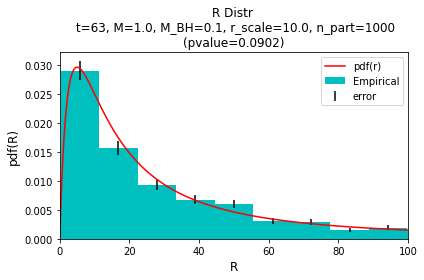

In [84]:
# Histogram Section #

# Generation of the normalized histogram and of the error bars
area = sum(np.diff(edges)*counts)
error = np.sqrt(counts) # Poissonian errors
bincenters = 0.5*(edges[1:]+edges[:-1])

normalized_counts_r, bin_edges_r, hist_r = plt.hist(radius,bins='auto',range=None,density=True,color='c',label='Empirical')
                                    # the bins selection is made through the 'auto' mode: maximum number of
                                    # bins between the 'Freedman–Diaconis rule' or the 'Sturge’s Rule' computation

error = np.divide(error, area) # the error bar must be rescaled since we normalized the histogram 
plt.errorbar(bincenters,normalized_counts_r,yerr=error,fmt='none',label='error',color='k')

## generation of the arrays containing some pdf's points
left_range = 0
right_range = r_scale*10
radius_pdf = np.empty(1000)
ascissa = np.linspace(left_range,right_range,1000)     
radius_pdf = pdf_r(ascissa,r_scale) 

plt.plot(ascissa,radius_pdf,color='r',label='pdf(r)')
plt.xlim(left_range,right_range)
plt.xlabel('R',fontsize=12)
plt.ylabel('pdf(R)',fontsize=12)
plt.title('R Distr \n t=63, M={}, M_BH={}, r_scale={}, n_part={}\n(pvalue={:3.3})'.format(M,M_BH,r_scale,Nparticles,pvalue))
plt.legend()
plt.tight_layout()
plt.savefig('R_histo_1000t.jpg')
# N.B. if you change the scale radius or if you want to see the whole histogram, you need to do a manual rescale

In [85]:
## Phi Distribution

In [86]:
## pdf and cdf of the phi angle
def pdf_p():
    return (2*math.pi)**(-1)
def cdf_p(p):
    return p*(2*math.pi)**(-1)

In [87]:
# Chisquare Section #

empirical,edges = np.histogram(phi,bins=10)
counts = np.copy(empirical) # used in the histogram Section
theorical = []
for i_bin in range(len(empirical)):
    if empirical[i_bin]>9:
        prob = cdf_p(edges[i_bin+1]) - cdf_p(edges[i_bin])
        theorical.append(prob*Nparticles)        
empirical = empirical[empirical>9] 

sta, pvalue = chisquare(empirical,theorical)
if pvalue>=0.05: print('pvalue: {}, test superato'.format(pvalue))
else: print('pvalue: {}, test non superato'.format(pvalue))

pvalue: 0.1381386995511748, test superato


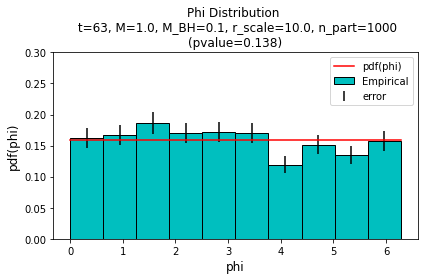

In [90]:
# Histogram Section # 

# Generation of the normalized histogram and of the error bars
area = sum(np.diff(edges)*counts)
error = np.sqrt(counts) # Poissonian errors
bincenters = 0.5*(edges[1:]+edges[:-1])

normalized_counts_p, Bin_edges_p, hist_p = plt.hist(phi,bins=10,range=None,density=True,color='c',edgecolor='black',label='Empirical')
error = error/area # the error bar must be rescaled since we normalized the histogram 
plt.errorbar(bincenters,normalized_counts_p,yerr=error,fmt='none',label='error',color='k')

## generation of the arrays containing some pdf's points
phi_pdf = np.empty(10)
ascissa = np.linspace(0,2*math.pi,10)
phi_pdf = np.ones(10)*pdf_p()        
        
plt.plot(ascissa,phi_pdf,color='r',label='pdf(phi)')
plt.ylim(0,0.3)
plt.xlabel('phi',fontsize=12)
plt.ylabel('pdf(phi)',fontsize=12)
plt.title('Phi Distribution \n t=63, M={}, M_BH={}, r_scale={}, n_part={}\n(pvalue={:3.3})'.format(M,M_BH,r_scale,Nparticles,pvalue))
plt.legend()
plt.tight_layout()
plt.savefig('Phi_histo_1000t.jpg')

In [91]:
## Theta Distribution

In [92]:
## pdf and cdf of the phi angle
def pdf_t(t):
    return 0.5*np.sin(t)
def cdf_t(t):
    return 0.5*(1-np.cos(t))

In [93]:
# Chisquare Section #

empirical,edges = np.histogram(theta,bins='auto')
counts = np.copy(empirical) # used in the Histogram Section
theorical = []
for i_bin in range(len(empirical)):
    if empirical[i_bin]>9:
        prob = cdf_t(edges[i_bin+1]) - cdf_t(edges[i_bin])
        theorical.append(prob*Nparticles)        
empirical = empirical[empirical>9] 

sta, pvalue = chisquare(empirical,theorical)
if pvalue>=0.05: print('pvalue: {}, test superato'.format(pvalue))
else: print('pvalue: {}, test non superato'.format(pvalue))

pvalue: 0.4130963773570687, test superato


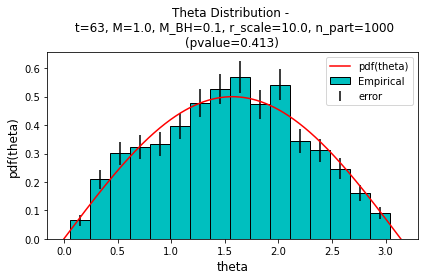

In [94]:
# Histogram Section #

# Generation of the normalized histogram and of the error bars
area = sum(np.diff(edges)*counts)
error = np.sqrt(counts) # Poissonian errors
bincenters = 0.5*(edges[1:]+edges[:-1])

normalized_counts_t, Bin_edges_t, hist_t = plt.hist(theta,bins='auto',range=None,density=True,color='c',edgecolor='black',label='Empirical')
error = error/area # the error bar must be rescaled since we normalized the histogram 
plt.errorbar(bincenters,normalized_counts_t,yerr=error,fmt='none',label='error',color='k')

## generation of the arrays containing some pdf's points
theta_pdf = np.empty(1000)
ascissa = np.linspace(0,math.pi,1000)
theta_pdf = pdf_t(ascissa)        
    
plt.plot(ascissa,theta_pdf,color='r',label='pdf(theta)')
plt.xlabel('theta',fontsize=12)
plt.ylabel('pdf(theta)',fontsize=12)
plt.title('Theta Distribution - \n t=63, M={}, M_BH={}, r_scale={}, n_part={}\n(pvalue={:3.3})'.format(M,M_BH,r_scale,Nparticles,pvalue))
plt.legend()
plt.tight_layout()
plt.savefig('Theta_histo_1000t.jpg')

In [120]:
# one schould also check the preservation of the Density Function #